## Setup

In [92]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, to_date, year, month, dayofmonth
from pyspark.sql.types import FloatType, IntegerType
import glob

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("GDELT Analysis") \
    .getOrCreate()

## Reading and Dataprep

In [133]:
directory = "/home/tiago/factored-datathon-2024-seed42/files"

gkg_files = glob.glob(directory + '/**/*export.CSV', recursive=True)
csv_files = [file for file in gkg_files if file.lower().endswith('.csv')]

# Read the CSV files into a single DataFrame
gdelt_df = spark.read.option("header", "true").option("sep", "\t").csv(csv_files)

# Convert SQLDATE to a proper date format
gdelt_df = gdelt_df.withColumn('SQLDATE', to_date(col('SQLDATE').cast('string'), 'yyyyMMdd'))

# Create year and month columns for easier analysis
gdelt_df = gdelt_df.withColumn('Year', year(col('SQLDATE'))) \
                   .withColumn('Month', month(col('SQLDATE'))) \
                   .withColumn('Day', dayofmonth(col('SQLDATE'))) \
                   .withColumn("GoldsteinScale", col("GoldsteinScale").cast(FloatType())) \
                   .withColumn("NumMentions", col("NumMentions").cast(IntegerType())) \
                   .withColumn("NumSources", col("NumSources").cast(IntegerType())) \
                   .withColumn("NumArticles", col("NumArticles").cast(IntegerType()))\
                   .withColumn("AvgTone", col("NumArticles").cast(FloatType()))

# Show the first few rows
gdelt_df.show(5)


+-------------+----------+---------+----+------------+----------+----------+-----------------+--------------------+----------------+-------------------+-------------------+---------------+---------------+---------------+----------+-------------+-----------------+--------------------+----------------+-------------------+-------------------+---------------+---------------+---------------+-----------+---------+-------------+-------------+---------+--------------+-----------+----------+-----------+-------+--------------+--------------------+---------------------+------------------+-------------+--------------+-------------------+--------------+--------------------+---------------------+------------------+-------------+--------------+-------------------+--------------+--------------------+---------------------+------------------+-------------+--------------+-------------------+---------+--------------------+-----+---+
|GLOBALEVENTID|   SQLDATE|MonthYear|Year|FractionDate|Actor1Code|Actor1Na

## Loading data with sanction codes

171: Reduce or eliminate economic sanctions
172: Impose economic sanctions
173: Reduce or eliminate military aid
174: Impose embargo
175: Cut off or reduce aid
...

http://data.gdeltproject.org/documentation/CAMEO.Manual.1.1b3.pdf

In [94]:
# List of CAMEO codes related to sanctions
sanction_codes = ['171', '172', '173', '174', '175']  # Replace with actual codes from the manual

# Filter GDELT data for sanction-related events
sanctions_df = gdelt_df.filter(gdelt_df.EventCode.isin(sanction_codes))

# Show the first few rows to verify
sanctions_df.show(5)

+-------------+----------+---------+----+------------+----------+----------+-----------------+--------------------+----------------+-------------------+-------------------+---------------+---------------+---------------+----------+-------------+-----------------+--------------------+----------------+-------------------+-------------------+---------------+---------------+---------------+-----------+---------+-------------+-------------+---------+--------------+-----------+----------+-----------+-----------------+--------------+--------------------+---------------------+------------------+-------------+--------------+-------------------+--------------+--------------------+---------------------+------------------+-------------+--------------+-------------------+--------------+--------------------+---------------------+------------------+-------------+--------------+-------------------+---------+--------------------+-----+---+
|GLOBALEVENTID|   SQLDATE|MonthYear|Year|FractionDate|Actor1Cod

## Geographic Distribution of Sanction-Related Events

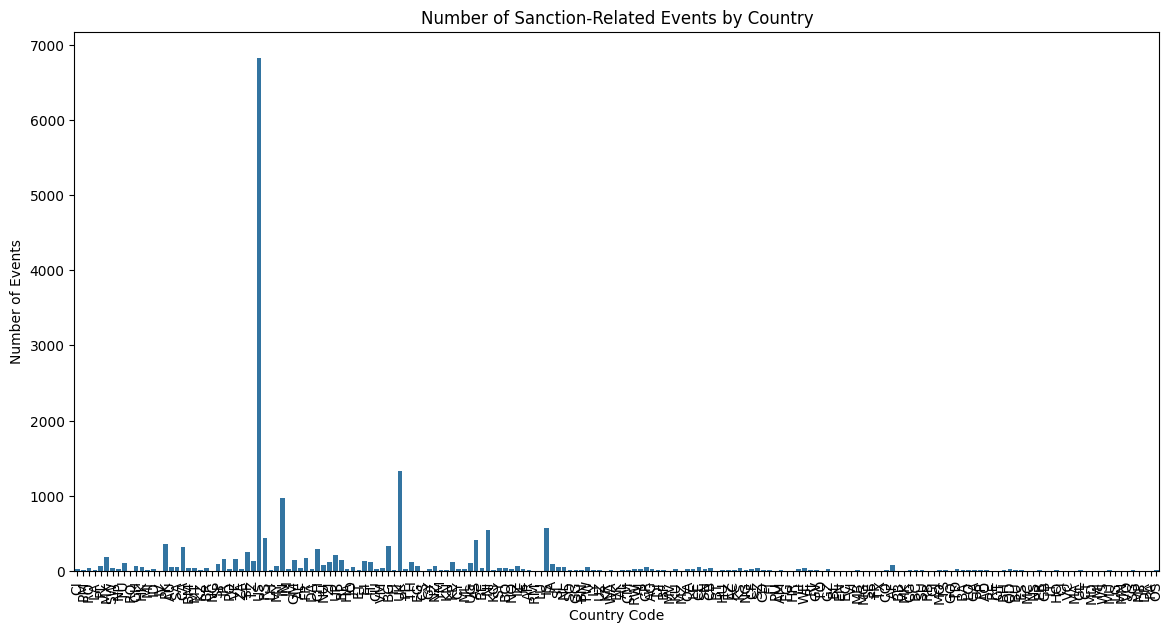

In [95]:
# Count the number of sanction events by country
sanctions_by_country = sanctions_df.groupBy('ActionGeo_CountryCode').count()

# Convert to Pandas for visualization (if needed)
sanctions_by_country_pd = sanctions_by_country.toPandas()

# Visualization (example using matplotlib)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.barplot(x='ActionGeo_CountryCode', y='count', data=sanctions_by_country_pd)
plt.title('Number of Sanction-Related Events by Country')
plt.xlabel('Country Code')
plt.ylabel('Number of Events')
plt.xticks(rotation=90)
plt.show()

## Temporal Trend of Sanction-Related Events

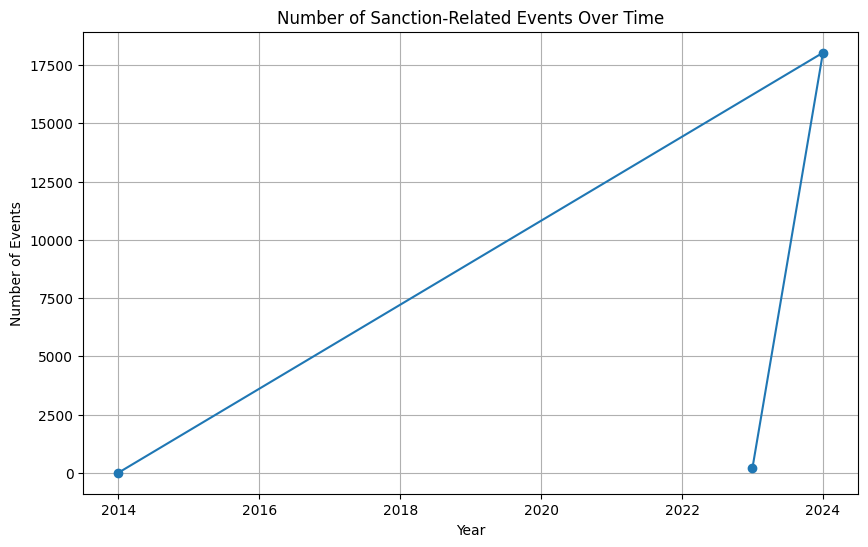

In [96]:
# Count the number of sanction events per year
sanctions_by_year = sanctions_df.groupBy('Year').count()

# Convert to Pandas for visualization
sanctions_by_year_pd = sanctions_by_year.toPandas()

# Plot the trend over time
plt.figure(figsize=(10, 6))
plt.plot(sanctions_by_year_pd['Year'], sanctions_by_year_pd['count'], marker='o')
plt.title('Number of Sanction-Related Events Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.grid(True)
plt.show()


## Sentiment Analysis Related to Sanctions

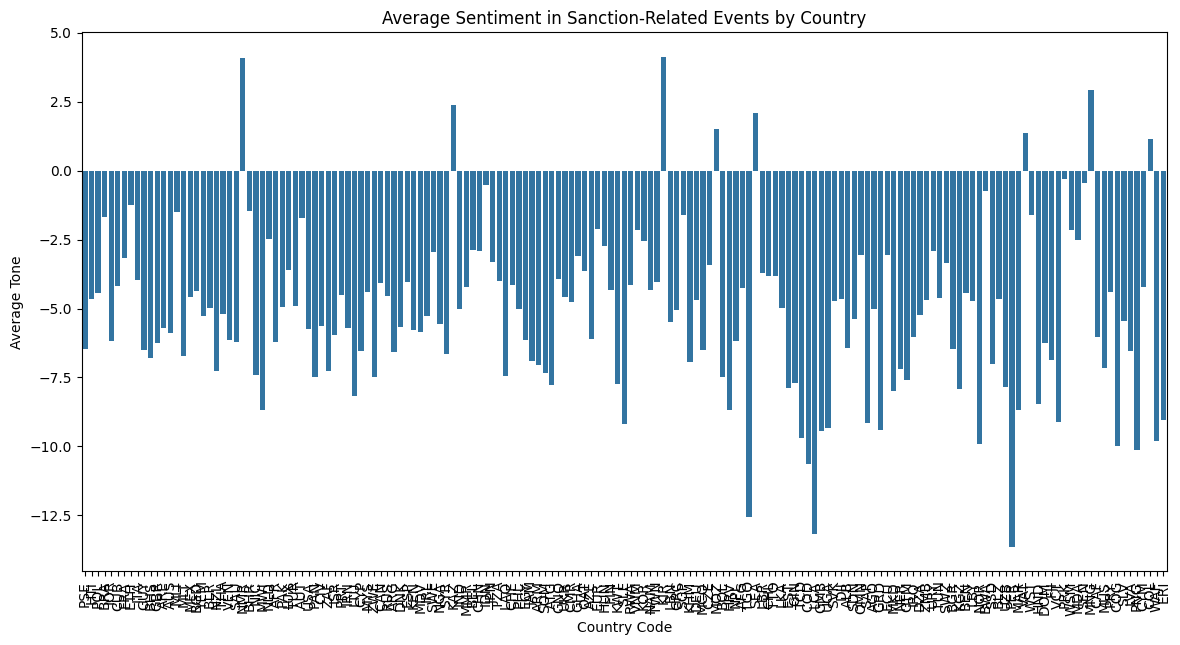

In [97]:
# Group by Actor1CountryCode and calculate average tone for sanction-related events
sanction_sentiment_by_country = sanctions_df.groupBy('Actor1CountryCode').agg(avg('AvgTone').alias('AvgTone'))

# Convert to Pandas for visualization
sanction_sentiment_by_country_pd = sanction_sentiment_by_country.toPandas()

# Visualization
plt.figure(figsize=(14, 7))
sns.barplot(x='Actor1CountryCode', y='AvgTone', data=sanction_sentiment_by_country_pd)
plt.title('Average Sentiment in Sanction-Related Events by Country')
plt.xlabel('Country Code')
plt.ylabel('Average Tone')
plt.xticks(rotation=90)
plt.show()

## Predictive Modeling Considering Sanctions

In [100]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Assemble features
assembler = VectorAssembler(inputCols=['GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles'], outputCol='features')
sanction_model_df = assembler.transform(sanctions_df)

# Example: Predict 'AvgTone' as the label
sanction_model_df = sanction_model_df.withColumn("AvgTone", col("AvgTone").cast(FloatType()))
sanction_model_df = sanction_model_df.select('features', col('AvgTone').alias('label'))

# Split into training and test sets
train_data, test_data = sanction_model_df.randomSplit([0.8, 0.2], seed=42)

# Initialize and fit the model
lr = LinearRegression(featuresCol='features', labelCol='label')
model = lr.fit(train_data)

# Predict on test data
predictions = model.transform(test_data)

# Show some predictions
predictions.select('features', 'label', 'prediction').show(5)


24/08/17 14:42:43 WARN Instrumentation: [356afd72] regParam is zero, which might cause numerical instability and overfitting.


+--------------------+----------+------------------+
|            features|     label|        prediction|
+--------------------+----------+------------------+
|[-9.1999998092651...| -9.166667|-5.980406616024028|
|[-9.1999998092651...|-3.9155319|-6.009700379595143|
|  [-9.0,1.0,1.0,1.0]|-12.769485|-5.956699880384669|
|  [-9.0,1.0,1.0,1.0]| -9.976247|-5.956699880384669|
|  [-9.0,2.0,1.0,2.0]|-2.5745258|-5.957749066722956|
+--------------------+----------+------------------+
only showing top 5 rows



## Identifying Key Actors in Sanction-Related Events

+--------------+-----+
|    Actor1Name|count|
+--------------+-----+
| UNITED STATES| 1973|
|          NULL| 1715|
|        POLICE| 1244|
|        PRISON|  537|
|UNITED KINGDOM|  434|
|   AUTHORITIES|  234|
|         JUDGE|  216|
|    GOVERNMENT|  200|
|      CRIMINAL|  189|
|       NIGERIA|  158|
+--------------+-----+
only showing top 10 rows



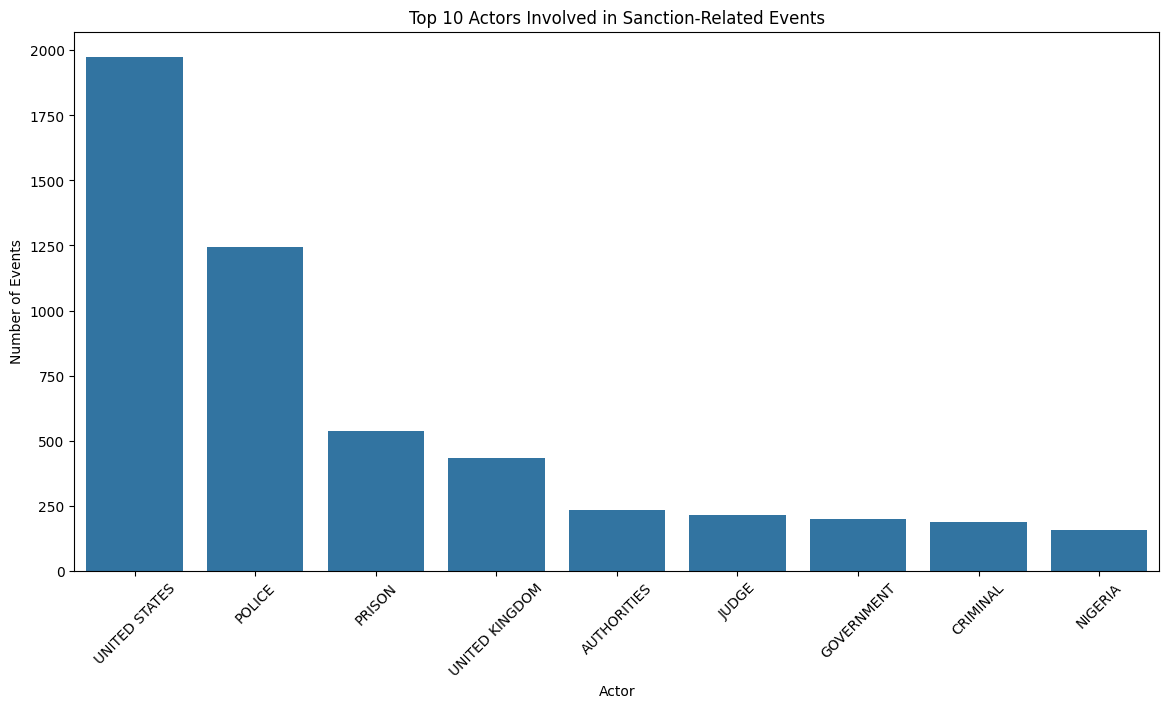

In [101]:
# Count the number of occurrences of each actor in sanction-related events
actors_df = sanctions_df.groupBy('Actor1Name').count().orderBy('count', ascending=False)

# Show top 10 actors
actors_df.show(10)

# Convert to Pandas for visualization
actors_pd = actors_df.toPandas()

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.barplot(x='Actor1Name', y='count', data=actors_pd.head(10))
plt.title('Top 10 Actors Involved in Sanction-Related Events')
plt.xlabel('Actor')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.show()


##  Sentiment Analysis Over Time for Specific Countries

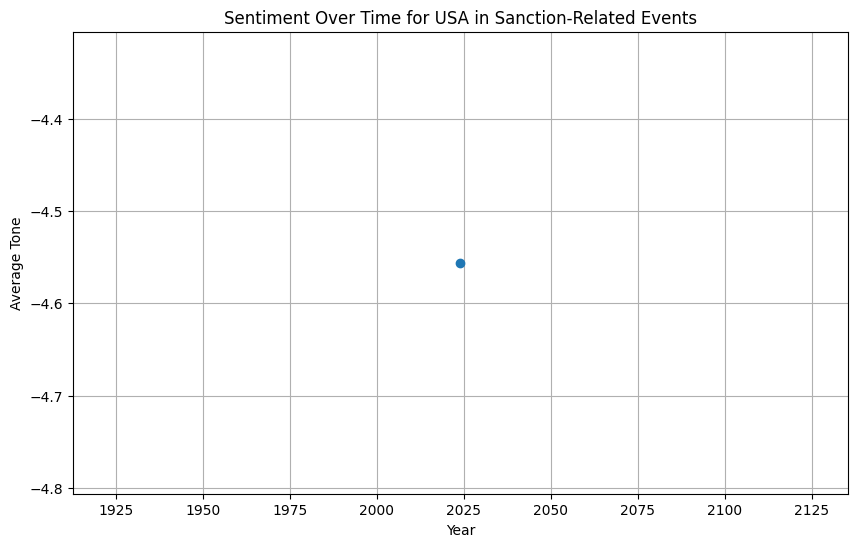

In [106]:
# Filter for a specific country (e.g., 'USA')
country_df = sanctions_df.filter(col('Actor1CountryCode') == 'RUS')

# Group by year and calculate average tone
sentiment_over_time = country_df.groupBy('Year').agg(avg('AvgTone').alias('AvgTone')).orderBy('Year')

# Convert to Pandas for visualization
sentiment_over_time_pd = sentiment_over_time.toPandas()

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(sentiment_over_time_pd['Year'], sentiment_over_time_pd['AvgTone'], marker='o')
plt.title('Sentiment Over Time for USA in Sanction-Related Events')
plt.xlabel('Year')
plt.ylabel('Average Tone')
plt.grid(True)
plt.show()


## Co-occurrence Analysis of Actors


In [127]:
import seaborn as sns

# Count the co-occurrence of Actor1 and Actor2
co_occurrence_df = sanctions_df.groupBy('Actor1Name', 'Actor2Name').count().orderBy('count', ascending=False)

# Convert to Pandas for visualization
co_occurrence_pd = co_occurrence_df.toPandas()

# Filter pairs with None as actors name
co_occurrence_pd = co_occurrence_pd.dropna(subset=['Actor1Name', 'Actor2Name'])

co_occurrence_pd.head(10)

,Actor1Name,Actor2Name,count
3,UNITED STATES,UNITED STATES,299
6,UNITED STATES,PRISON,151
7,POLICE,UNITED STATES,151
12,NEW ZEALAND,POLICE,69
14,UNITED KINGDOM,UNITED KINGDOM,62
15,PRISON,UNITED STATES,53
17,UNITED STATES,POLICE,50
18,POLICE,UNITED KINGDOM,49
19,JUDGE,UNITED STATES,42
21,AUTHORITIES,UNITED STATES,41


## Temporal Analysis of Sanction Events by QuadClass


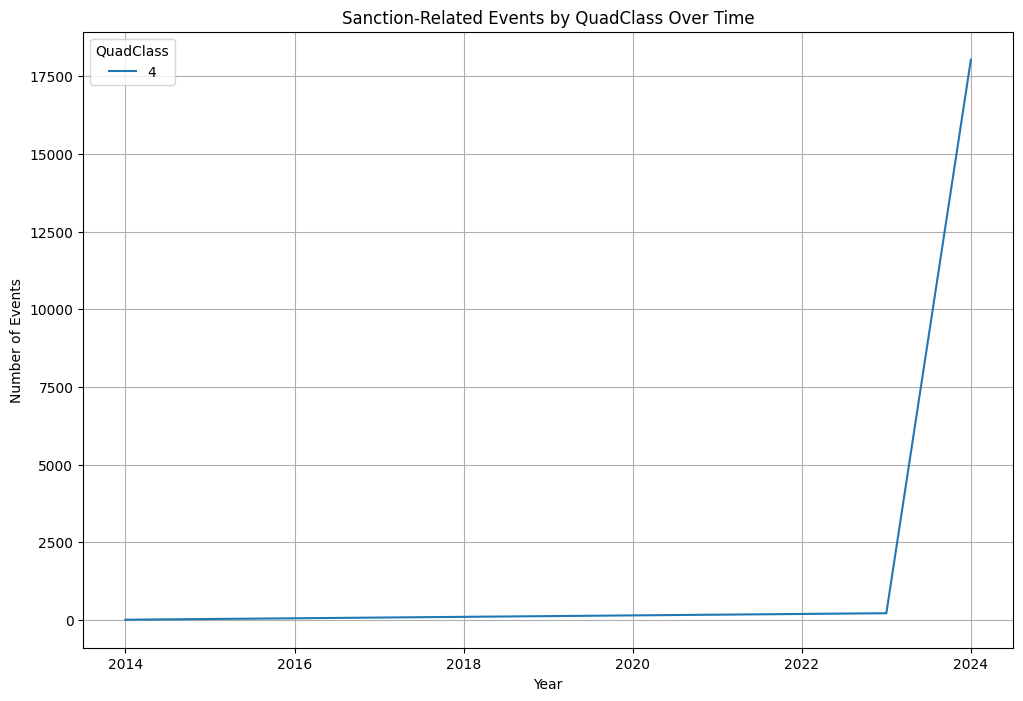

In [128]:
# Group by year and QuadClass to count events
quadclass_over_time = sanctions_df.groupBy('Year', 'QuadClass').count().orderBy('Year')

# Convert to Pandas for visualization
quadclass_over_time_pd = quadclass_over_time.toPandas()

# Visualization
plt.figure(figsize=(12, 8))
sns.lineplot(data=quadclass_over_time_pd, x='Year', y='count', hue='QuadClass')
plt.title('Sanction-Related Events by QuadClass Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.grid(True)
plt.show()


## Impact Analysis: Sanctions and Media Attention

+---------+------------------+
|EventCode|       AvgArticles|
+---------+------------------+
|      173|11.974358974358974|
|      172|10.894796380090497|
|      175|  9.67601246105919|
|      174| 8.511730205278592|
|      171| 7.818181818181818|
+---------+------------------+



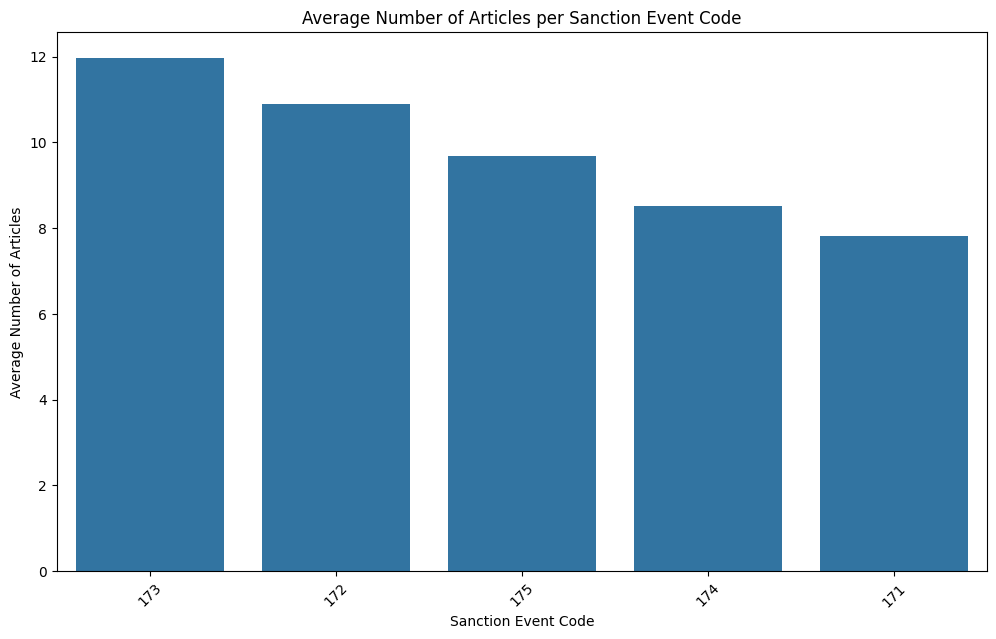

In [129]:
# Group by EventCode (representing different sanction types) and calculate average number of articles
media_attention_df = sanctions_df.groupBy('EventCode').agg(avg('NumArticles').alias('AvgArticles')).orderBy('AvgArticles', ascending=False)

# Show the results
media_attention_df.show()

# Convert to Pandas for visualization
media_attention_pd = media_attention_df.toPandas()

# Visualization
plt.figure(figsize=(12, 7))
sns.barplot(x='EventCode', y='AvgArticles', data=media_attention_pd)
plt.title('Average Number of Articles per Sanction Event Code')
plt.xlabel('Sanction Event Code')
plt.ylabel('Average Number of Articles')
plt.xticks(rotation=45)
plt.show()


## Predicting Goldstein Scale Based on Event Attributes

In [134]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=['NumMentions', 'NumSources', 'NumArticles', 'AvgTone'], outputCol='features')
goldstein_model_df = assembler.transform(gdelt_df)

# Assume 'GoldsteinScale' is the label you want to predict
goldstein_model_df = goldstein_model_df.select('features', col('GoldsteinScale').alias('label'))

# Split into training and test sets
train_data, test_data = goldstein_model_df.randomSplit([0.8, 0.2], seed=42)

# Initialize and train the model
lr = LinearRegression(featuresCol='features', labelCol='label')
model = lr.fit(train_data)

# Predict on test data
predictions = model.transform(test_data)

# Show some predictions
predictions.select('features', 'label', 'prediction').show(5)

24/08/17 14:55:23 WARN Instrumentation: [92d36dd6] regParam is zero, which might cause numerical instability and overfitting.
24/08/17 14:55:23 WARN Instrumentation: [92d36dd6] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


+-----------------+-----+------------------+
|         features|label|        prediction|
+-----------------+-----+------------------+
|[1.0,1.0,1.0,1.0]|-10.0|0.3279763577800481|
|[1.0,1.0,1.0,1.0]|-10.0|0.3279763577800481|
|[1.0,1.0,1.0,1.0]|-10.0|0.3279763577800481|
|[1.0,1.0,1.0,1.0]|-10.0|0.3279763577800481|
|[1.0,1.0,1.0,1.0]|-10.0|0.3279763577800481|
+-----------------+-----+------------------+
only showing top 5 rows



## Analyzing the Effect of Sanctions on International Relations

+-----------------+-----------------+
|Actor1CountryCode|AvgGoldsteinScale|
+-----------------+-----------------+
|              BHS|             -5.0|
|              NZL|             -5.0|
|              HTI|             -5.0|
|              ARE|             -5.0|
|              JOR|             -5.0|
|              MLI|             -5.0|
|              ITA|             -5.0|
|              MLT|             -5.0|
|              YEM|             -5.0|
|              MEX|             -5.0|
+-----------------+-----------------+
only showing top 10 rows



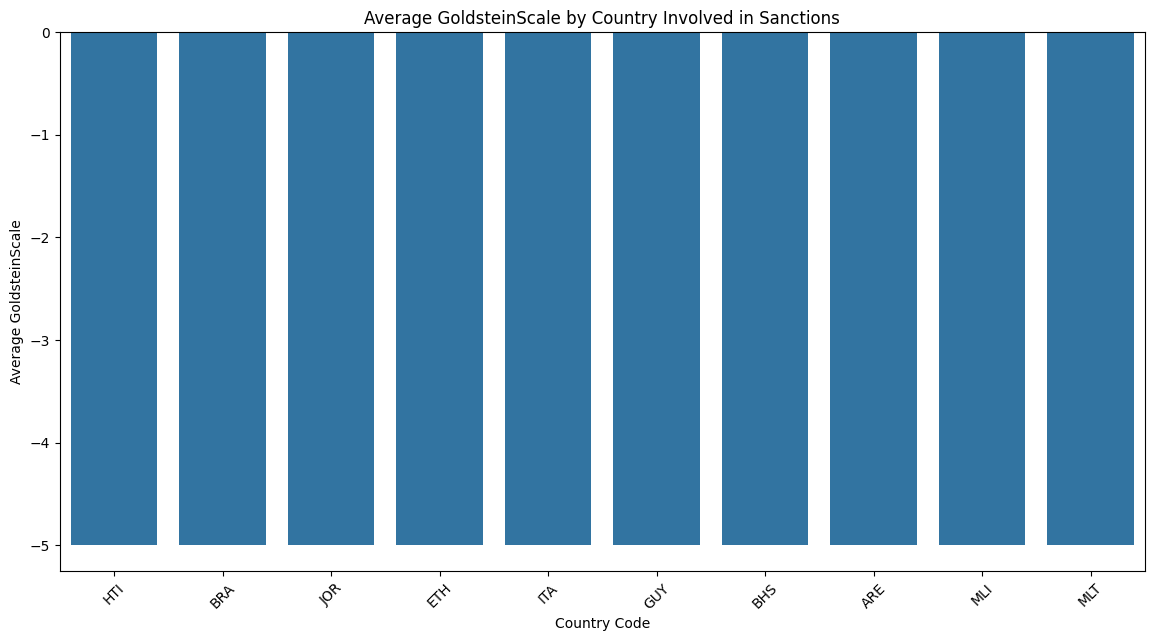

In [135]:
# Group by Actor1CountryCode and calculate the average GoldsteinScale for sanctions
relation_effect_df = sanctions_df.groupBy('Actor1CountryCode').agg(avg('GoldsteinScale').alias('AvgGoldsteinScale')).orderBy('AvgGoldsteinScale', ascending=False)

# Show the results
relation_effect_df.show(10)

# Convert to Pandas for visualization
relation_effect_pd = relation_effect_df.toPandas()

# Visualization
plt.figure(figsize=(14, 7))
sns.barplot(x='Actor1CountryCode', y='AvgGoldsteinScale', data=relation_effect_pd.head(10))
plt.title('Average GoldsteinScale by Country Involved in Sanctions')
plt.xlabel('Country Code')
plt.ylabel('Average GoldsteinScale')
plt.xticks(rotation=45)
plt.show()


## Clustering Events Based on Attributes

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-4.4000000953674...|         0|
|[-5.0,2.0,1.0,2.0...|         0|
|[-2.0,6.0,1.0,6.0...|         0|
|[-2.0,4.0,1.0,4.0...|         0|
|[7.0,2.0,1.0,2.0,...|         0|
+--------------------+----------+
only showing top 5 rows



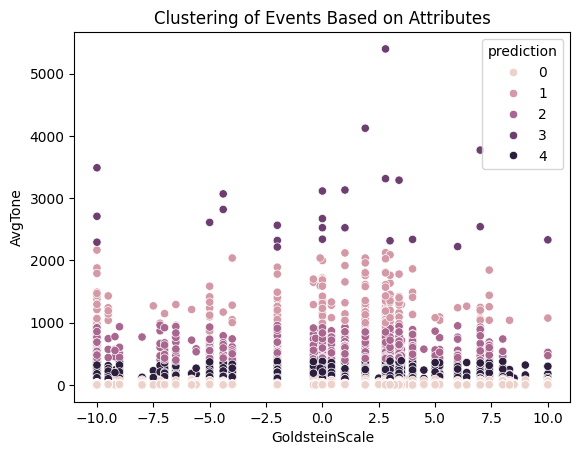

: 

In [136]:
from pyspark.ml.clustering import KMeans

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=['GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone'], outputCol='features')
cluster_df = assembler.transform(gdelt_df)

# Initialize and train the KMeans model
kmeans = KMeans(k=5, seed=42, featuresCol='features')
model = kmeans.fit(cluster_df)

# Predict cluster labels
clusters = model.transform(cluster_df)

# Show cluster assignment
clusters.select('features', 'prediction').show(5)

# Convert to Pandas for visualization (if needed)
clusters_pd = clusters.toPandas()

# Visualization (optional)
sns.scatterplot(x='GoldsteinScale', y='AvgTone', hue='prediction', data=clusters_pd)
plt.title('Clustering of Events Based on Attributes')
plt.xlabel('GoldsteinScale')
plt.ylabel('AvgTone')
plt.show()
